In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import glob
from scipy.io import loadmat
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\xl313\OneDrive\Documents\GitHub\poseTrackingXL\faceNet')
# import faceNetArchitectures as FNA

In [2]:
gpu = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpu],'GPU')

In [3]:
def s6(inputs_shape=(128,128,3), data_augmentation=None, base_filters=25):
    inputs = keras.Input(inputs_shape)
    # normalize inputs
    x = preprocessing.Rescaling(scale=1. / 127.5, offset=-1.0)(inputs)
    # augment images
    if data_augmentation is not None:
        x = data_augmentation(x)
    # big, strided conv and maxpool, 128->32
    x = layers.Conv2D(filters=base_filters, kernel_size=7, padding='same', strides=2,
                      activation='selu', kernel_initializer='lecun_normal')(x) # base filter: depth, kernel size: look at 7 x 7 region at a time, stride: downsample by 2, selu: non-linearlity
    x = layers.Conv2D(filters=base_filters*2, kernel_size=3, padding='same',
                      activation='selu', kernel_initializer='lecun_normal')(x)
    x = layers.MaxPool2D(2)(x) # reduce dimensions, focusing on the most prominent features
    # Repeated fine-scale conv and maxpool
    # 32->16
    x = layers.Conv2D(filters=base_filters * 2, kernel_size=3, padding='same',
                      activation='selu', kernel_initializer='lecun_normal')(x)
    x = layers.Conv2D(filters=base_filters * 4, kernel_size=3, padding='same',
                      activation='selu', kernel_initializer='lecun_normal')(x)
    x = layers.MaxPool2D(2)(x)
    # 16->1
    x = layers.Conv2D(filters=base_filters * 4, kernel_size=3, padding='same',
                      activation='selu', kernel_initializer='lecun_normal')(x)
    singleView_pred = layers.GlobalAveragePooling2D(name='view_features')(x)
    return keras.Model(inputs, singleView_pred)

def j6(inputs_shape=(128, 128, 4), viewMdl=s6()):
    nViews = inputs_shape[-1]
    inputs = layers.Input(inputs_shape)
    allSlices = layers.Lambda(lambda z: tf.split(z, nViews, axis=-1))(inputs)
    allSlices = [tf.image.grayscale_to_rgb(slice_tensor) for slice_tensor in
                 allSlices] 
    
    feature_layer_num = [i for i, x in enumerate(viewMdl.layers) if x.name == 'view_features'][0]
    feature_layer = viewMdl.layers[feature_layer_num]
    x = layers.AlphaDropout(0.2, name='feature_dropout')(feature_layer.output)
    x = layers.Dense(10, name='feature_hidden', activation='selu', kernel_initializer='lecun_normal')(x)
    view_weight = layers.Dense(1, name='view_weight')(x)

    featMdl = keras.Model(viewMdl.input,view_weight) # feed into single view model 

    # Make predictions for every single view
    allPreds = [featMdl(view) for view in allSlices]

    # Take 'weights'/scores and average, using preset and non-tunable weights
    view_weights = layers.Concatenate(name='view_weights')([x for x in allPreds])
    joint_pred = layers.Dense(1, activation='sigmoid', name='joint_pred')
    joint_pred_out = joint_pred(view_weights)
    joint_pred.set_weights([np.ones((4, 1)), np.zeros((1))])
    joint_pred.trainable = False

    return keras.Model(inputs, joint_pred_out)

In [4]:
labelDir = "Z:\Sherry\poseTrackingXL\SeedCarryingLabeling\LabeledData"
faceNetDir = r'C:\Users\xl313\OneDrive\Documents\GitHub\poseTrackingXL\faceNet'
allFn = glob.glob(labelDir+'/seedLabel_*.mat') + glob.glob(labelDir+'/manualSeedRelabel*.mat')
allIms = []
allLabels = []
side_idx = np.asarray([0, 1, 3, 4]) # remove the 2 top cameras
for fn in allFn:
    if '_XL' in fn:
        tmp = loadmat(fn)
        allIms.append(tmp['allIms'])
        allLabels.append(tmp['seedLabels'].flatten())
    else: # excluding SC's top cameras
        tmp = loadmat(fn)
        allIms.append(tmp['allIms'][:, :, side_idx])
        allLabels.append(tmp['seedLabels'].flatten())

In [5]:
allIms = np.transpose(np.concatenate(allIms, axis=3), [3,0,1,2])
allLabels = np.concatenate(allLabels, axis=0)
# select only valid image/labels
validLabels = np.isfinite(allLabels)
allIms = allIms[validLabels]
allLabels = allLabels[validLabels]
nLabels = validLabels.sum()
print(f'Total valid training data: {nLabels}')
print(f'Numbers of "has seed" frames: {sum(allLabels)}')
allIms = allIms.astype('float32')
allLabels = allLabels.astype('float32')

Total valid training data: 15491
Numbers of "has seed" frames: 4469.0


In [ ]:
validFrac = 0.1
nValid = round(validFrac * len(allLabels))
allInd = np.random.permutation(len(allLabels))
allTrainInd = allInd[nValid:]
allValidInd = allInd[:nValid]
classBalanceDict = {0:len(allTrainInd)/(allLabels[allTrainInd] == 0).sum()/2,
                   1:len(allTrainInd)/(allLabels[allTrainInd] == 1).sum()/2}
print(classBalanceDict)

#define input layer
inputs_shape = allIms.shape[1:]
#train from a naive network (be sure to make all layers trainable in joint model!)
data_augmentation = Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomTranslation(height_factor = 0.2, width_factor=0.2, fill_mode="reflect", interpolation="bilinear"),
        preprocessing.RandomRotation(factor=.1, fill_mode="reflect", interpolation="bilinear")
    ]
)
viewMdl = s6((128,128,3), data_augmentation)
# viewMdl = FNA.s5((128,128,1), data_augmentation)
# make joint prediction model
jointMdl = j6([128,128,4], viewMdl)

# Train joint model
## maybe use learning rate 1e-3 when using j4 model?
opt = tf.keras.optimizers.Adam(learning_rate=3e-4) # used to be 5e-4
jointMdl.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=tf.keras.metrics.AUC(), loss_weights=[0.75, 0.25]),

jointMdl.summary()

# define callbacks to reduce LR
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.25, patience=10)
stop_tr = tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=31,
                                           restore_best_weights=False)

hist = jointMdl.fit(x=allIms[allTrainInd], y=allLabels[allTrainInd],
                    validation_data=(allIms[allValidInd], allLabels[allValidInd]),
                    epochs=1000, batch_size=100, class_weight=classBalanceDict,
                    callbacks=[reduce_lr, stop_tr]) # original batch size 200

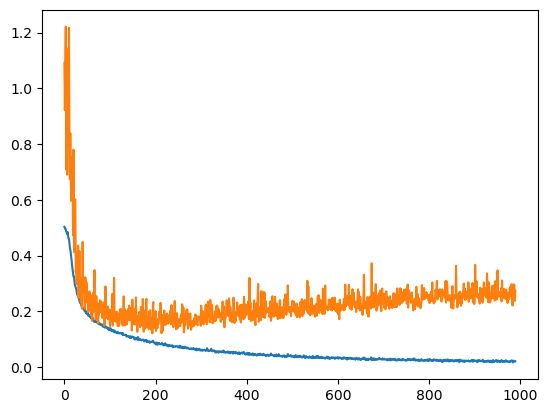

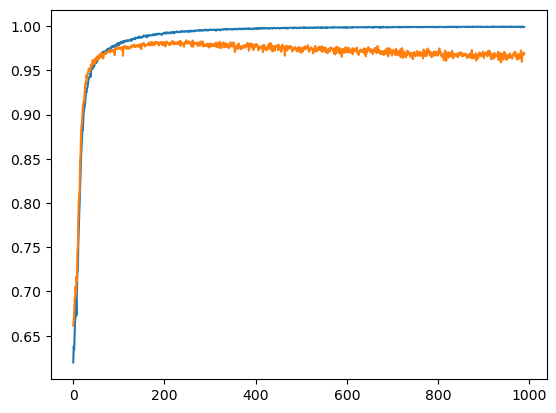

([<matplotlib.lines.Line2D at 0x26f5c876608>],
 None)

In [13]:
# plot training history
h = hist.history
plt.plot(h['loss'][10:]),plt.plot(h['val_loss'][10:]),plt.show()
plt.plot(h['auc'][10:]),plt.plot(h['val_auc'][10:]),plt.show()

In [ ]:
# select indices for display
testIndices = allValidInd

# define new network with view-specific weights and make predictions
weights_layer = [l for l in jointMdl.layers if l.name=='view_weights'][0]
jp_layer = [l for l in jointMdl.layers if l.name=='joint_pred'][0]
predMdl = tf.keras.Model(inputs=jointMdl.input, outputs=[jp_layer.output, weights_layer.output])
val = predMdl.predict(allIms[testIndices], batch_size=100) # original batch size 200

# # display 10 random images
# for i in np.random.randint(len(testIndices), size=(10,1)):
#     plt.imshow(valIms[i[0]], cmap='gray'),
#     weightString = [str(v+1) + '-' + str(np.round(val[1][i,v], decimals=1)) for v in range(6)]
#     weightString = ', '.join(weightString)
#     plt.title('Score-' + str(np.round(val[0][i][0], decimals=3)) + ': ' + weightString),
#     plt.show(),

# show histogram of predicted values for true and false targets separately
jp = val[0].flatten()
plt.hist([jp[allLabels[testIndices]==0],jp[allLabels[testIndices]==1]],density=True),
plt.show(),

In [7]:

jointMdl.save(faceNetDir+'/j4-xl-041525.keras')
viewMdl.save(faceNetDir+'/s5-xl-041525.keras')